In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy import constants as const
from scipy.optimize import minimize
from scipy import integrate
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import row, column,gridplot
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [3]:
rawfile = np.genfromtxt('ps6_rv_data.txt') ##Import data from file location
X = rawfile[:,0] ##X data
Y = rawfile[:,1] ##Y data
Yerr = rawfile[:,2] ##Y error data

In [4]:
## Optimal Estimation
def negLnLikelihood(param,x,y,err):
    return -(np.sum(((-1/2)*np.power((get_model(param,x)- y)/(err), 2))+np.log(1/(err*np.sqrt(2*np.pi)))))

In [5]:
def get_model(params,x): ##evaluate the y-values of the model, given the current guess of parameter values
    ## params [K, phi, gamma(, P)]
    if len(params) > 3:
        P = params[-1]
    else:
        P = 6.5
    model = params[0]*np.cos((2*np.pi*x/P)+params[1])+params[2] ##vector of y-values, given the current guess of parameter values and assumed model form
    
    return model

In [6]:
def get_log_likelihood(params, x, y, error): ##obtain the chi2 value of the model y-values given current parameters vs. the measured y-values
    
    chi2 = np.sum(((get_model(params, x)-y)/error)**2) ##calculate chi2

    return chi2

In [7]:
def perturb_pick(param): ##select a model parameter to perturb
    
    picker = np.random.randint(0,len(param)) ##this function randomly selects which model parameter to perturb based on how many parameters are in the model
    
    return picker

In [8]:
def propose_param(active_param, stepsize, perturb_value): ##obtain a trial model parameter for the current step
    
    try_param = np.copy(active_param) ##the trial parameter value for this step is based on the value of the parameter in the previous step (copy, so as not to overwrite the previous step value)
    
    step = stepsize*np.random.normal(loc = 0, scale = 1) ##decide how much to perturb the trial parameter based on the stepsize multiplied by a random number drawn from a Gaussian distribution
    
    try_param[perturb_value] = active_param[perturb_value]+step[perturb_value] ##this is the trial value of the parameter for the current step (i.e. the value from the last step plus the perturbation)
    
    return try_param

In [9]:
def step_eval(params, stepsize, x, y, error, perturb_value): ##evaluate whether to step to the new trial value
    
    chi2_old = get_log_likelihood(params, x, y, error) ##the chi2 value of the parameters from the previous step
    
    try_param = propose_param(params, stepsize, perturb_value) ## read in the trial model parameters for the current step

    chi2_try = get_log_likelihood(try_param, x, y, error) ## the chi2 value of the trial model parameters for the current step
        
    
    if chi2_try < chi2_old: ##if the chi2 value of the trial model parameters < the chi2 value of the parameters from the previous step
        
        new_param = np.copy(try_param) ##accept the trial parameters; the trial parameters become the accepted parameters for this step
        
        acceptvalue = 1 ##record acceptance of the step
        
    else: ##if the chi2 value of the trial model parameters > the chi2 value of the parameters from the previous step
        
        step_prob = np.exp(0.5*(chi2_old-chi2_try)) ##the trial parameters may still be accepted, with some conditional probability based on this formula; the higher the probability, the more likely the trial parameters will be accepted
        
        test_value = np.random.uniform(0,1) ##choose a random value between 0 and 1 to compare against the conditional probability of acceptance of the trial parameters

        if step_prob > test_value: ##if the conditional probability of acceptance of the trial parameters > the random value between 0 and 1
        
            new_param = np.copy(try_param) ##accept the trial parameters; the trial parameters become the accepted parameters for this step
        
            acceptvalue = 1 ##record acceptance of the step
            
        else: ##if the conditional probability of acceptance of the trial parameters < the random value between 0 and 1
            
            new_param = np.copy(params) ##reject the trial parameters; the parameters from the previous step become the accepted parameters for this step
            
            acceptvalue = -1 ##record rejection of the step
        
        
    return new_param, acceptvalue

In [10]:
def MCMC(params, stepsize, x, y, error, n_steps): ##run the whole MCMC routine, calling the subroutines
    
    chain = np.zeros((n_steps, len(params))) ##define an empty array to store parameter values for each step in the chain
    
    accept_chain = np.zeros((n_steps, len(params))) ##define an empty array to keep track of acceptance/rejection at each step
    
    chi2_chain = np.zeros(n_steps) ##define an empty array to keep track of the chi2 value at each step in the chain
    
    for i in range(n_steps): ##perform each step
    
        perturb_value = perturb_pick(params) ##select which model value to perturb for this step
    
        params, acceptvalue = step_eval(params, stepsize, x, y, error, perturb_value) ##evaluate whether to step to the new trial value or remain at the parameter values of the previous step
        
        chain[i,:] = params ##store the accepted parameters for this step (i.e. either the new parameter values (if step accepted) or the old parameter values (if step rejected))
        
        accept_chain[i,perturb_value] = acceptvalue ##record acceptance/rejection
        
        chi2_chain[i] = get_log_likelihood(params, x, y, error) ##record chi2 value
        
    return chain, accept_chain, chi2_chain

In [11]:
# param_guess=np.array([15,25,125000]) # Put your initial guess here [A, B, P]

# minResult=minimize(negLnLikelihood,param_guess,args=(times,obliqu,obliqSig))

# bestFits = minResult.x
# invHess = minResult.hess_inv

# print('Message: {}'.format(minResult.message))
# print('Success?: {}\n'.format(minResult.success))
# print('The covariance matrix is: \n{}\n'.format(invHess))
# print('[A, B, P] = {}\n'.format(bestFits))
# print('Marginalized Error Bars: {}'.format(np.sqrt(invHess.diagonal())))

In [12]:
# params0 = np.array([10.0,2.5]) ## good initial guess for intercept and slope, for example

# stepsize = np.array([1.0,0.5]) ## reasonable values for the step size in each parameter, for example

# n_steps = 1000000 ## number of steps to run the MCMC


# chain, accept_chain, chi2_chain = MCMC(params0, stepsize, X, Y, Yerr, n_steps) ##run the MCMC and output the chains

# n_accept_int = len(np.where(accept_chain[:,0] == 1)[0]) ##the number of accepted steps when intercept was perturbed
# n_reject_int = len(np.where(accept_chain[:,0] == -1)[0]) ##the number of rejected steps when intercept was perturbed

# n_accept_slope = len(np.where(accept_chain[:,1] == 1)[0]) ##the number of accepted steps when slope was perturbed
# n_reject_slope = len(np.where(accept_chain[:,1] == -1)[0]) ##the number of rejected steps when slope was perturbed

# print "intercept accept rate: ", 1.0*n_accept_int/(n_accept_int+n_reject_int)
# print "slope accept rate: ", 1.0*n_accept_slope/(n_accept_slope+n_reject_slope)

# median_int = np.median(chain[:,0]) ##median value for the model intercept fit
# std_int = np.std(chain[:,0]) ##standard deviation for the model intercept fit
# median_slope = np.median(chain[:,1]) ##median value for the model slope fit
# std_slope = np.std(chain[:,1]) ##standard deviation for the model slope fit
# best_params = np.array((median_int,median_slope))

# print "median intercept: ", median_int
# print "intercept STD: ", std_int
# print "median slope: ", median_slope
# print "slope STD: ", std_slope


# Problem 1

# a)

In [13]:
param_guess_optEst=np.array([75,0,-25]) # [K, phi, gamma]
minResult=minimize(negLnLikelihood,param_guess_optEst,args=(X,Y,Yerr))
optEstForGuess = minResult.x
invHess = minResult.hess_inv
print('[K, phi, gamma] = {}\n'.format(optEstForGuess))
print('Marginalized Error Bars: {}'.format(np.sqrt(invHess.diagonal())))

[K, phi, gamma] = [ 71.87027135   0.34731838 -23.45845396]

Marginalized Error Bars: [0.03879085 0.00467018 0.0415571 ]


# b)

In [14]:
params0 = np.append(optEstForGuess,6.5) ## [K, phi, gamma, P]

stepsize = np.array([1.5,0.02,1,0.00001]) ## reasonable values for the step size in each parameter, for example

n_steps = 100000 ## number of steps to run the MCMC


chain, accept_chain, chi2_chain = MCMC(params0, stepsize, X, Y, Yerr, n_steps) ##run the MCMC and output the chains

n_accept_K = len(np.where(accept_chain[:,0] == 1)[0]) ##the number of accepted steps when K was perturbed
n_reject_K = len(np.where(accept_chain[:,0] == -1)[0]) ##the number of rejected steps when K was perturbed

n_accept_phi = len(np.where(accept_chain[:,1] == 1)[0]) ##the number of accepted steps when phi was perturbed
n_reject_phi = len(np.where(accept_chain[:,1] == -1)[0]) ##the number of rejected steps when phi was perturbed

n_accept_gam = len(np.where(accept_chain[:,2] == 1)[0]) ##the number of accepted steps when gamma was perturbed
n_reject_gam = len(np.where(accept_chain[:,2] == -1)[0]) ##the number of rejected steps when gamma was perturbed

n_accept_P = len(np.where(accept_chain[:,3] == 1)[0]) ##the number of accepted steps when P was perturbed
n_reject_P = len(np.where(accept_chain[:,3] == -1)[0]) ##the number of rejected steps when P was perturbed


print ("K accept rate: ", 1.0*n_accept_K/(n_accept_K+n_reject_K))
print ("phi accept rate: ", 1.0*n_accept_phi/(n_accept_phi+n_reject_phi))
print ("gamma accept rate: ", 1.0*n_accept_gam/(n_accept_gam+n_reject_gam))
print ("P accept rate: ", 1.0*n_accept_P/(n_accept_P+n_reject_P))

median_K = np.median(chain[:,0]) ##median value for the model intercept fit
std_K = np.std(chain[:,0]) ##standard deviation for the model intercept fit
median_phi = np.median(chain[:,1]) ##median value for the model slope fit
std_phi = np.std(chain[:,1]) ##standard deviation for the model slope fit
median_gam = np.median(chain[:,2]) ##median value for the model intercept fit
std_gam = np.std(chain[:,2]) ##standard deviation for the model intercept fit
median_P = np.median(chain[:,3]) ##median value for the model slope fit
std_P = np.std(chain[:,3]) ##standard deviation for the model slope fit

best_params = np.array((median_K,median_phi,median_gam,median_P))
param_stds = np.array((std_K,std_phi,std_gam,std_P))

print ("\nBest Parameter Fits: ", best_params)
print ("Parameter STDs: ", param_stds)


chainChi = np.concatenate((chain,(np.array([chi2_chain])).T),axis=1)
chainChiSort = chainChi[chainChi[:,-1].argsort()]
chainSort = (chainChiSort.T[:-1]).T
confPairs = chainSort[:(int(len(chainSort)*(.68)))]

KConfMin = np.amin(confPairs[:,0])
KConfMax = np.amax(confPairs[:,0])

phiConfMin = np.amin(confPairs[:,1])
phiConfMax = np.amax(confPairs[:,1])

gammaConfMin = np.amin(confPairs[:,2])
gammaConfMax = np.amax(confPairs[:,2])

PConfMin = np.amin(confPairs[:,3])
PConfMax = np.amax(confPairs[:,3])

print("\nThe K 68% confidence interval is [{}, {}]".format(KConfMin, KConfMax))
print("The phi 68% confidence interval is [{}, {}]".format(phiConfMin, phiConfMax))
print("The gamma 68% confidence interval is [{}, {}]".format(gammaConfMin, gammaConfMax))
print("The P 68% confidence interval is [{}, {}]".format(PConfMin, PConfMax))


K accept rate:  0.311310592459605
phi accept rate:  0.2697914149955706
gamma accept rate:  0.2985486385990164
P accept rate:  0.24089278597050617

Best Parameter Fits:  [ 75.06967668  -6.05625997 -25.19741038   6.49716812]
Parameter STDs:  [1.05323898e+00 2.49655328e+00 6.65933188e-01 1.10406953e-03]

The K 68% confidence interval is [73.45547541453966, 76.96120007854847]
The phi 68% confidence interval is [-8.751931555473297, -4.251591244802662]
The gamma 68% confidence interval is [-26.64214376342042, -24.159830465675]
The P 68% confidence interval is [6.495974939744817, 6.497964438908982]


In [15]:
probDistK, edgesK = np.histogram(chain[:,0],200,weights=np.ones_like(chain[:,0])/float(len(chain[:,0])))
probDistPhi, edgesPhi = np.histogram(chain[:,1],200,weights=np.ones_like(chain[:,1])/float(len(chain[:,1])))
probDistGamma, edgesGamma = np.histogram(chain[:,2],200,weights=np.ones_like(chain[:,2])/float(len(chain[:,2])))
probDistP, edgesP = np.histogram(chain[:,3],200,weights=np.ones_like(chain[:,3])/float(len(chain[:,3])))

pK = figure(
   tools="pan,box_zoom,reset,save", title="K Probability Distribution",
   x_axis_label='K', y_axis_label='PDF')
pPhi = figure(
   tools="pan,box_zoom,reset,save", title="Phi Probability Distribution",
   x_axis_label='Phi (Radians)', y_axis_label='PDF')
pGamma = figure(
   tools="pan,box_zoom,reset,save", title="Gamma Probability Distribution",
   x_axis_label='Gamma', y_axis_label='PDF')
pPeriod = figure(
   tools="pan,box_zoom,reset,save", title="Period Probability Distribution",
   x_axis_label='Period(days)', y_axis_label='PDF')

pK.quad(top=probDistK, bottom=0, left=edgesK[:-1], right=edgesK[1:], alpha=0.4)
pPhi.quad(top=probDistPhi, bottom=0, left=edgesPhi[:-1], right=edgesPhi[1:], alpha=0.4)
pGamma.quad(top=probDistGamma, bottom=0, left=edgesGamma[:-1], right=edgesGamma[1:], alpha=0.4)
pPeriod.quad(top=probDistP, bottom=0, left=edgesP[:-1], right=edgesP[1:], alpha=0.4)

show(row(pK,pPhi,pGamma,pPeriod))

# c)

In [16]:
xMod = (np.linspace(14200, 15400,num=50000))

p1c = figure(
   tools="pan,box_zoom,reset,save", title="Best Fit",
   x_axis_label='Time (days)', y_axis_label='Radial Velocity (m/s)')


err_xs = []
err_ys = []

for xs, ys, yerrs in zip(X%median_P, Y, Yerr):
    err_xs.append((xs, xs))
    err_ys.append((ys - yerrs, ys + yerrs))


p1c.line(xMod%median_P,get_model(best_params,xMod),color='black',line_width=2)
p1c.multi_line(err_xs, err_ys, color='pink')
p1c.circle(X%median_P,Y,color = 'red')

show(p1c)

# d)

In [17]:
chain2, accept_chain2, chi2_chain2 = MCMC(params0, stepsize, X, Y, Yerr, n_steps) ##run the MCMC and output the chains

n_accept_K2 = len(np.where(accept_chain2[:,0] == 1)[0]) ##the number of accepted steps when K was perturbed
n_reject_K2 = len(np.where(accept_chain2[:,0] == -1)[0]) ##the number of rejected steps when K was perturbed

n_accept_phi2 = len(np.where(accept_chain2[:,1] == 1)[0]) ##the number of accepted steps when phi was perturbed
n_reject_phi2 = len(np.where(accept_chain2[:,1] == -1)[0]) ##the number of rejected steps when phi was perturbed

n_accept_gam2 = len(np.where(accept_chain2[:,2] == 1)[0]) ##the number of accepted steps when gamma was perturbed
n_reject_gam2 = len(np.where(accept_chain2[:,2] == -1)[0]) ##the number of rejected steps when gamma was perturbed

n_accept_P2 = len(np.where(accept_chain2[:,3] == 1)[0]) ##the number of accepted steps when P was perturbed
n_reject_P2 = len(np.where(accept_chain2[:,3] == -1)[0]) ##the number of rejected steps when P was perturbed


print ("K accept rate: ", 1.0*n_accept_K2/(n_accept_K2+n_reject_K2))
print ("phi accept rate: ", 1.0*n_accept_phi2/(n_accept_phi2+n_reject_phi2))
print ("gamma accept rate: ", 1.0*n_accept_gam2/(n_accept_gam2+n_reject_gam2))
print ("P accept rate: ", 1.0*n_accept_P2/(n_accept_P2+n_reject_P2))

median_K2 = np.median(chain2[:,0]) ##median value for the model intercept fit
std_K2 = np.std(chain2[:,0]) ##standard deviation for the model intercept fit
median_phi2 = np.median(chain2[:,1]) ##median value for the model slope fit
std_phi2 = np.std(chain2[:,1]) ##standard deviation for the model slope fit
median_gam2 = np.median(chain2[:,2]) ##median value for the model intercept fit
std_gam2 = np.std(chain2[:,2]) ##standard deviation for the model intercept fit
median_P2 = np.median(chain2[:,3]) ##median value for the model slope fit
std_P2 = np.std(chain2[:,3]) ##standard deviation for the model slope fit

best_params2 = np.array((median_K2,median_phi2,median_gam2,median_P2))
param_stds2 = np.array((std_K2,std_phi2,std_gam2,std_P2))

print ("\nBest Parameter Fits: ", best_params2)
print ("Parameter STDs: ", param_stds2)


chainChi2 = np.concatenate((chain2,(np.array([chi2_chain2])).T),axis=1)
chainChiSort2 = chainChi2[chainChi2[:,-1].argsort()]
chainSort2 = (chainChiSort2.T[:-1]).T
confPairs2 = chainSort2[:(int(len(chainSort2)*(.68)))]

KConfMin2 = np.amin(confPairs2[:,0])
KConfMax2 = np.amax(confPairs2[:,0])

phiConfMin2 = np.amin(confPairs2[:,1])
phiConfMax2 = np.amax(confPairs2[:,1])

gammaConfMin2 = np.amin(confPairs2[:,2])
gammaConfMax2 = np.amax(confPairs2[:,2])

PConfMin2 = np.amin(confPairs2[:,3])
PConfMax2 = np.amax(confPairs2[:,3])

print("\nThe K 68% confidence interval is [{}, {}]".format(KConfMin2, KConfMax2))
print("The phi 68% confidence interval is [{}, {}]".format(phiConfMin2, phiConfMax2))
print("The gamma 68% confidence interval is [{}, {}]".format(gammaConfMin2, gammaConfMax2))
print("The P 68% confidence interval is [{}, {}]".format(PConfMin2, PConfMax2))


K accept rate:  0.31312560542460444
phi accept rate:  0.26541758022722745
gamma accept rate:  0.299864368916547
P accept rate:  0.23353675561405607

Best Parameter Fits:  [ 75.08787727  -6.0387739  -25.22434208   6.49717626]
Parameter STDs:  [1.05128225e+00 2.54061590e+00 6.70124799e-01 1.12350411e-03]

The K 68% confidence interval is [73.55883339512029, 77.18805352608557]
The phi 68% confidence interval is [-8.75160285621583, -4.37576146761986]
The gamma 68% confidence interval is [-26.50336886303645, -24.19058895303447]
The P 68% confidence interval is [6.495977142872964, 6.497909475530018]


# e)

In [18]:
dToSec = 24*60*60
minMassChain = ((np.power(((chain[:,3]*dToSec)/(2*np.pi*const.G)),(1/3)))*\
            chain[:,0]*np.power(((np.random.normal(1.70,0.13,\
            len(chain[:,3])))*const.M_sun),(2/3))).value

In [19]:
chainChi2MinMass = np.concatenate((minMassChain.reshape(len(minMassChain),1),(np.array([chi2_chain])).T),axis=1)
chainChiMinMassSort = chainChi2MinMass[chainChi2MinMass[:,-1].argsort()]
chainSortMinMass = (chainChiMinMassSort.T[:-1]).T
confPairsMinMass = chainSortMinMass[:(int(len(chainSortMinMass)*(.68)))]

median_minMass = np.median(minMassChain) ##median value for the model intercept fit
std_minMass = np.std(minMassChain)

minMassConfMin = np.amin(confPairsMinMass[:,0])
minMassConfMax = np.amax(confPairsMinMass[:,0])

print("Minimum planet mass best fit: {} kg\n".format(median_minMass))
print("Standard deviation of minimum planet mass: {} kg\n".format(std_minMass))
print("The minimum planet mass 68% confidence interval is \n[{} kg, {} kg]".format(minMassConfMin, minMassConfMax))

Minimum planet mass best fit: 1.8566029769486965e+27 kg

Standard deviation of minimum planet mass: 9.856061282176855e+25 kg

The minimum planet mass 68% confidence interval is 
[1.3694631946378572e+27 kg, 2.253079232793794e+27 kg]


# f)

/Users/mayafuller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  """
/Users/mayafuller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  if sys.path[0] == '':
/Users/mayafuller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
/Users/mayafuller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped

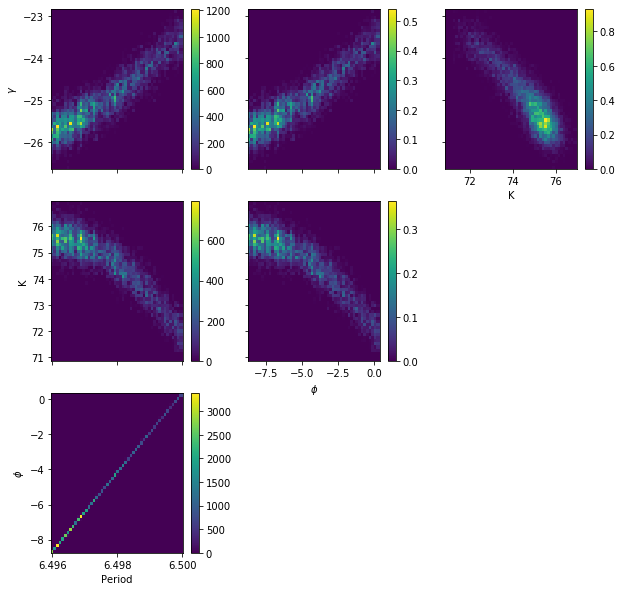

In [20]:
fig = plt.figure(figsize=(10,10))

# Gamma-Period
pltGP = fig.add_subplot(331)
plt.hist2d(chain[:,3], chain[:,2], bins=50,normed=True)
plt.colorbar()
plt.ylabel(r'$\gamma$')
plt.setp(pltGP.get_xticklabels(),visible=False)

# Phi-Gamma
pltPhG = fig.add_subplot(332,sharey=pltGP)
plt.hist2d(chain[:,1], chain[:,2], bins=50,normed=True)
plt.colorbar()
plt.setp(pltPhG.get_xticklabels(),visible=False)
plt.setp(pltPhG.get_yticklabels(),visible=False)

# K-Gamma
pltKG = fig.add_subplot(333,sharey=pltGP)
plt.hist2d(chain[:,0], chain[:,2], bins=50,normed=True)
plt.colorbar()
plt.xlabel("K")
plt.setp(pltKG.get_yticklabels(),visible=False)

# K-Period
pltKP = fig.add_subplot(334,sharex=pltGP)
plt.hist2d(chain[:,3], chain[:,0], bins=50,normed=True)
plt.colorbar()
plt.ylabel("K")
plt.setp(pltKP.get_xticklabels(),visible=False)

# K-Phi
pltKPh = fig.add_subplot(335)
plt.hist2d(chain[:,1], chain[:,0], bins=50,normed=True)
plt.colorbar()
plt.xlabel(r'$\phi$')
plt.setp(pltKPh.get_yticklabels(),visible=False)


# Phi-Period
pltPhP = fig.add_subplot(337,sharex=pltGP)
plt.hist2d(chain[:,3], chain[:,1], bins=50,normed=True)
plt.colorbar()
plt.xlabel("Period")
plt.ylabel(r'$\phi$')

plt.show()

my_path = os.getcwd()
fig.savefig(my_path + '/prob1f.png')


# Problem 2